In [ ]:
# Train LSTM on MediaPipe-style 3D joint coordinates (33 joints, 99D input) — constructed from raw MoCap

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



Epoch 1/30, Loss: 0.7969
Epoch 2/30, Loss: 0.5958
Epoch 3/30, Loss: 0.4654
Epoch 4/30, Loss: 0.3824
Epoch 5/30, Loss: 0.3523
Epoch 6/30, Loss: 0.3058
Epoch 7/30, Loss: 0.2835
Epoch 8/30, Loss: 0.2591
Epoch 9/30, Loss: 0.2492
Epoch 10/30, Loss: 0.2407
Epoch 11/30, Loss: 0.2335
Epoch 12/30, Loss: 0.2172
Epoch 13/30, Loss: 0.2172
Epoch 14/30, Loss: 0.1997
Epoch 15/30, Loss: 0.2167
Epoch 16/30, Loss: 0.2176
Epoch 17/30, Loss: 0.1948
Epoch 18/30, Loss: 0.1828
Epoch 19/30, Loss: 0.1759
Epoch 20/30, Loss: 0.1767
Epoch 21/30, Loss: 0.1814
Epoch 22/30, Loss: 0.1725
Epoch 23/30, Loss: 0.1949
Epoch 24/30, Loss: 0.1735
Epoch 25/30, Loss: 0.1667
Epoch 26/30, Loss: 0.1663
Epoch 27/30, Loss: 0.1559
Epoch 28/30, Loss: 0.1478
Epoch 29/30, Loss: 0.1418
Epoch 30/30, Loss: 0.1678


In [ ]:

# ==========================
# MediaPipe Joint Construction from Raw MoCap
# ==========================
mediapipe_joint_map = {
    'LEFT_SHOULDER': ['L.ShoulderFront', 'L.ShoulderRear'],
    'RIGHT_SHOULDER': ['R.ShoulderFront', 'R.ShoulderRear'],
    'LEFT_ELBOW': ['L.LowerArmLateral', 'L.LowerArmMedial'],
    'RIGHT_ELBOW': ['R.LowerArmLateral', 'R.LowerArmMedial'],
    'LEFT_WRIST': ['L.WristLateral', 'L.WristMedial'],
    'RIGHT_WRIST': ['R.WristLateral', 'R.WristMedial'],
    'LEFT_HIP': ['LASIS', 'LPSIS'],
    'RIGHT_HIP': ['RASIS', 'RPSIS'],
    'LEFT_KNEE': ['L.KneeLateral', 'L.KneeMedial'],
    'RIGHT_KNEE': ['R.KneeLateral', 'R.KneeMedial'],
    'LEFT_ANKLE': ['L.AnkleLateral', 'L.AnkleMedial'],
    'RIGHT_ANKLE': ['R.AnkleLateral', 'R.AnkleMedial'],
    'LEFT_HEEL': ['L.FootHeel'],
    'RIGHT_HEEL': ['R.FootHeel'],
    'LEFT_FOOT_INDEX': ['L.ToeLateral', 'L.ToeMedial'],
    'RIGHT_FOOT_INDEX': ['R.ToeLateral', 'R.ToeMedial'],
    'LEFT_PINKY': ['L.WristLateral'],
    'RIGHT_PINKY': ['R.WristLateral'],
    'LEFT_INDEX': ['L.WristMedial'],
    'RIGHT_INDEX': ['R.WristMedial'],
    'LEFT_THUMB': ['LACR'],
    'RIGHT_THUMB': ['RACR'],
    'C7': ['C7'],
    'CLAV': ['CLAV'],
    'Head_Top': ['Head_Top'],
}

mediapipe_xyz_cols = [f"{joint}_{axis}" for joint in mediapipe_joint_map for axis in ['X', 'Y', 'Z']]


In [ ]:

# ==========================
# Dataset Class with Smoothing
# ==========================
class MediaPipeMoCapDataset(Dataset):
    def __init__(self, folder, joint_angle_columns, seq_len=500):
        self.X, self.y = [], []
        self.seq_len = seq_len

        xyz_all, angle_all = [], []
        for file in sorted(glob(os.path.join(folder, "*.csv"))):
            df = pd.read_csv(file)
            if not all(col in df.columns for col in joint_angle_columns):
                continue

            engineered = {}
            for target_joint, source_joints in mediapipe_joint_map.items():
                for axis in ['X', 'Y', 'Z']:
                    cols = [f"{j}_{axis}" for j in source_joints if f"{j}_{axis}" in df.columns]
                    if cols:
                        engineered[f"{target_joint}_{axis}"] = df[cols].mean(axis=1)
                    else:
                        engineered[f"{target_joint}_{axis}"] = 0.0

            xyz_df = pd.DataFrame(engineered)[mediapipe_xyz_cols]
            angles = df[joint_angle_columns]

            # Smooth the joint angle ground truth using Savitzky-Golay filter
            smoothed_angles = savgol_filter(angles.values, window_length=11, polyorder=3, axis=0)

            xyz_all.append(xyz_df.values)
            angle_all.append(smoothed_angles)

        xyz = np.concatenate(xyz_all)
        y = np.concatenate(angle_all)

        self.scaler_x = StandardScaler().fit(xyz)
        self.scaler_y = StandardScaler().fit(y)

        norm_x = self.scaler_x.transform(xyz)
        norm_y = self.scaler_y.transform(y)

        for i in range(0, len(norm_x) - seq_len, seq_len):
            self.X.append(norm_x[i:i+seq_len])
            self.y.append(norm_y[i:i+seq_len])

        self.X = torch.tensor(np.stack(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.stack(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ==========================
# LSTM Model with deeper layers and lower dropout
# ==========================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)


In [ ]:

# ==========================
# Training Setup
# ==========================
INPUT_DIM = len(mediapipe_xyz_cols)
OUTPUT_DIM = 36
HIDDEN_DIM = 256
SEQ_LEN = 500
BATCH_SIZE = 8
EPOCHS = 30


In [ ]:

joint_angle_columns = [
    "pelvis_tilt", "pelvis_list", "pelvis_rotation",
    "hip_flexion_r", "hip_adduction_r", "hip_rotation_r", "knee_angle_r", "knee_angle_r_beta",
    "ankle_angle_r", "subtalar_angle_r", "mtp_angle_r",
    "hip_flexion_l", "hip_adduction_l", "hip_rotation_l", "knee_angle_l", "knee_angle_l_beta",
    "ankle_angle_l", "subtalar_angle_l", "mtp_angle_l",
    "lumbar_extension", "lumbar_bending", "lumbar_rotation",
    "arm_flex_r", "arm_add_r", "arm_rot_r", "elbow_flex_r", "pro_sup_r", "wrist_flex_r", "wrist_dev_r",
    "arm_flex_l", "arm_add_l", "arm_rot_l", "elbow_flex_l", "pro_sup_l", "wrist_flex_l", "wrist_dev_l"
]


In [ ]:

folder = "Subject_Data/S5/sync_data/filtered"
dataset = MediaPipeMoCapDataset(folder, joint_angle_columns, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = LSTMModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# ==========================
# Training Loop
# ==========================
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")

# Save model
torch.save(model.state_dict(), "lstm_mediapipe_model.pth")


In [ ]:

def plot_predictions(model, dataset, angle_scaler, joint_angle_columns, channels=[0, 5, 10]):
    model.eval()

    # Pick a sample
    X_sample, y_sample = dataset[0]  # (500, 99) and (500, 36)
    X_sample = X_sample.unsqueeze(0)  # Add batch dim: (1, 500, 99)

    with torch.no_grad():
        y_pred = model(X_sample).squeeze(0).numpy()  # (500, 36)

    y_true = y_sample.numpy()

    # Denormalize
    y_pred_denorm = angle_scaler.inverse_transform(y_pred)
    y_true_denorm = angle_scaler.inverse_transform(y_true)

    # Plot
    time = np.arange(0, y_true.shape[0])
    plt.figure(figsize=(20, 15))

    for i, idx in enumerate(channels):
        plt.subplot(len(channels), 1, i+1)
        plt.plot(time, y_true_denorm[:, idx], label='Ground Truth', color='blue', linewidth=2)
        plt.plot(time, y_pred_denorm[:, idx], '--', label='Predicted', color='orange', linewidth=2)
        plt.title(f"Joint Angle {idx} — {joint_angle_columns[idx]}")
        plt.xlabel("Time Step")
        plt.ylabel("Angle (degrees)")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Evaluation metrics
    mse = mean_squared_error(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    r2 = r2_score(y_true_denorm, y_pred_denorm)
    print(f"\n📊 Evaluation Metrics:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")


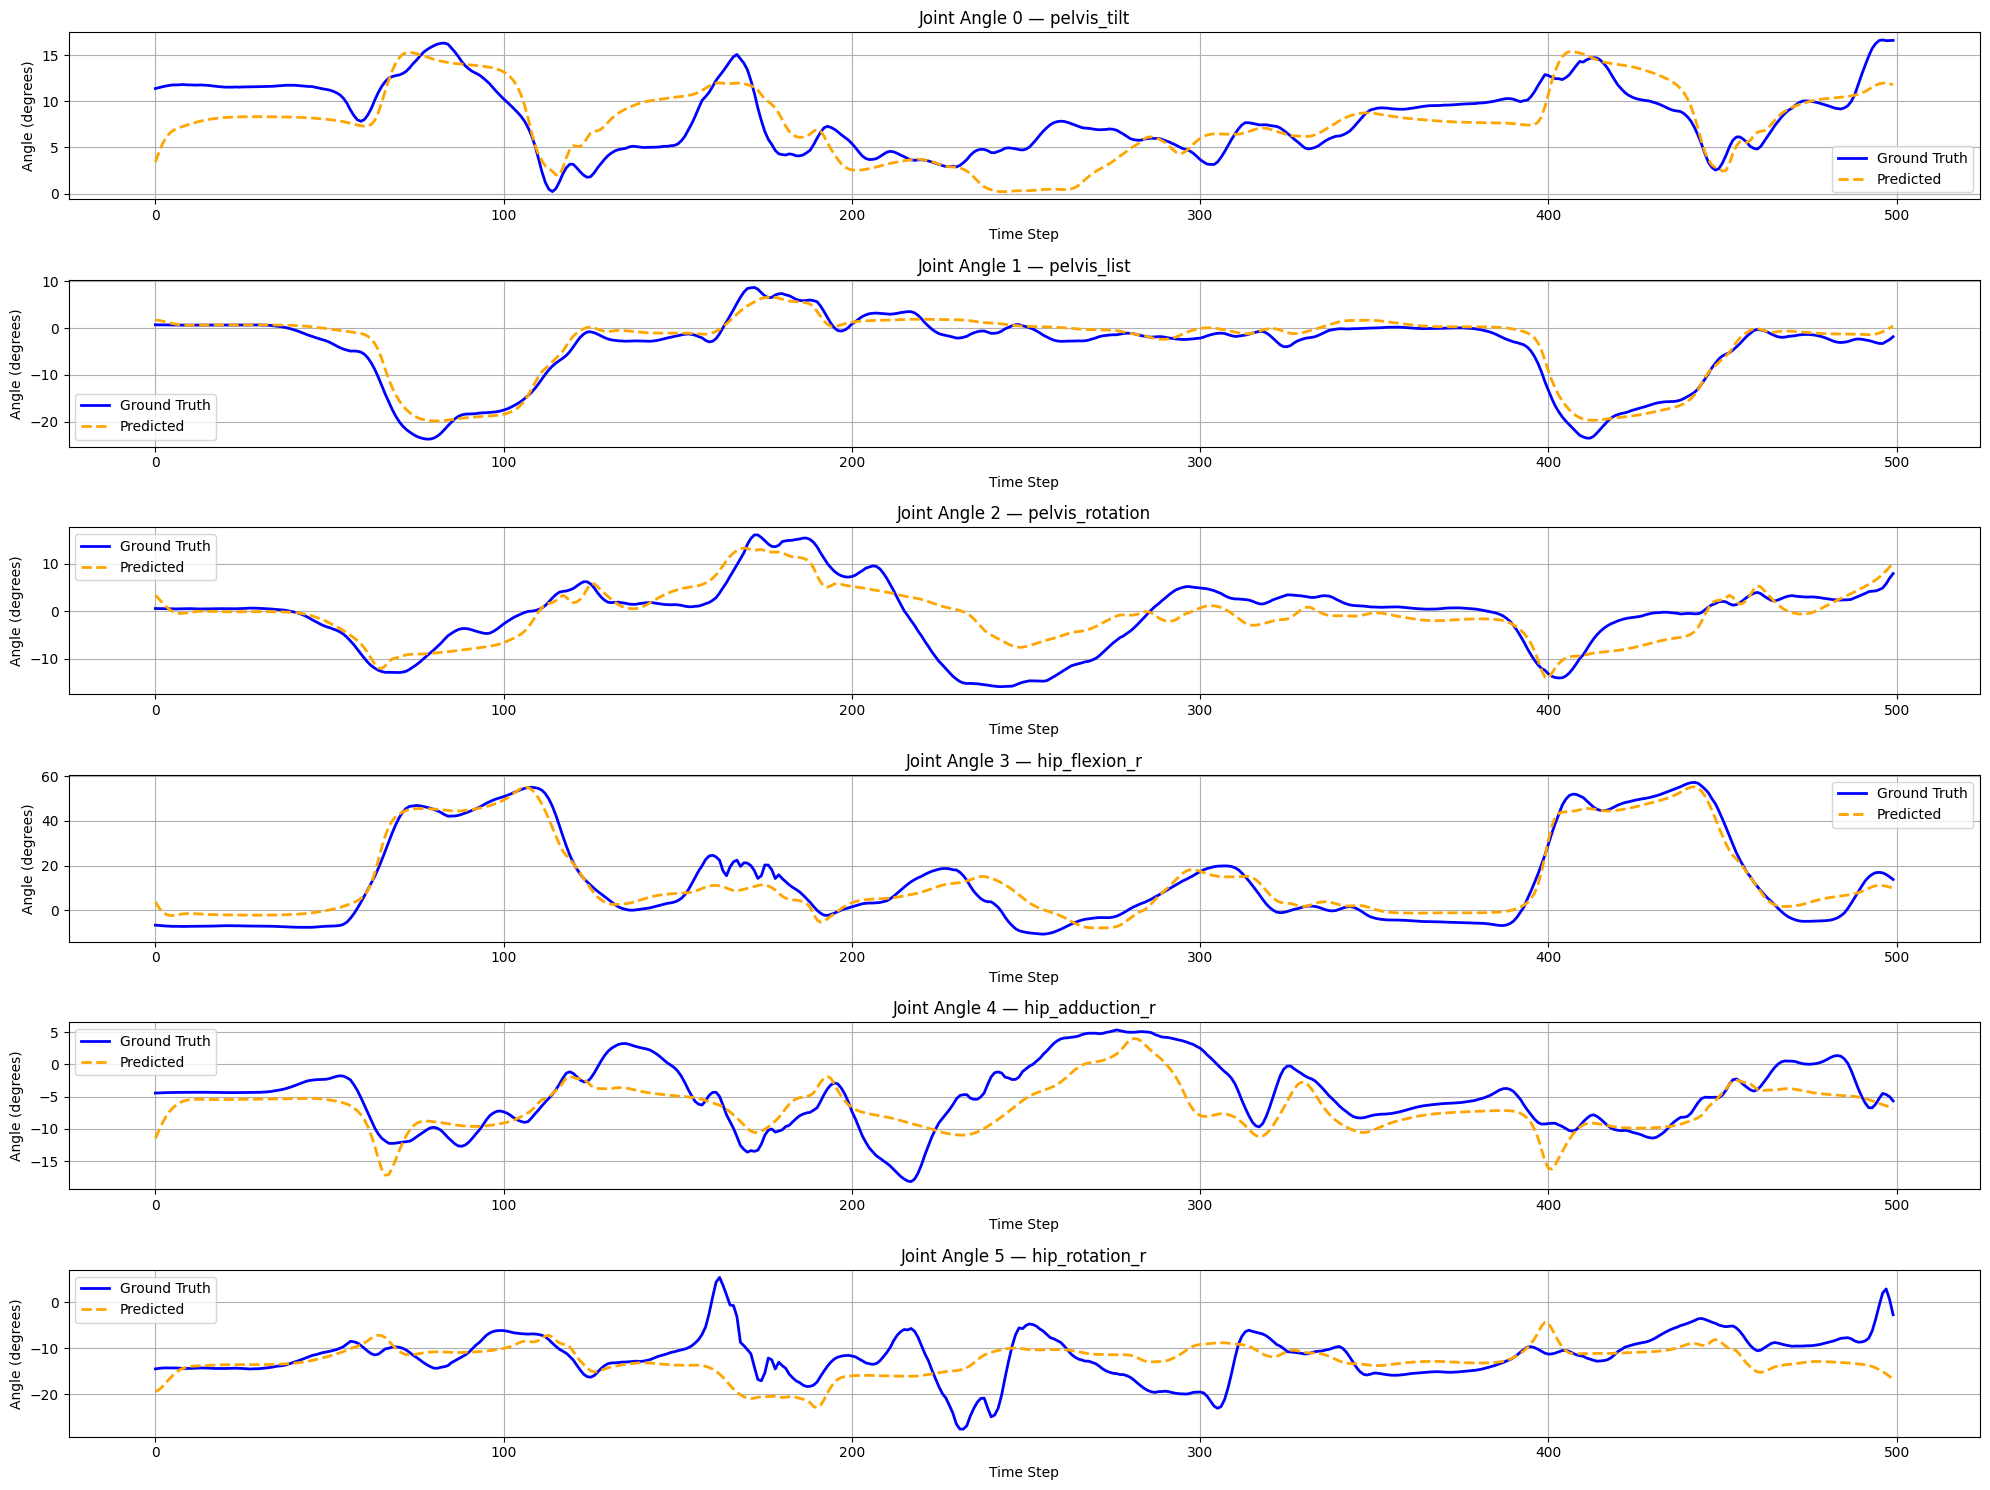


📊 Evaluation Metrics:
  MSE: 16.1959
  MAE: 2.5318
  R² Score: 0.3302


In [20]:
plot_predictions(model, dataset, dataset.scaler_y, joint_angle_columns, channels=[0,1,2,3,4,5])


C:\Users\daksh\AppData\Local\Temp\ipykernel_23256\4233874317.py:15: DtypeWarning: Columns (213,214,215,217,218,219,220,221,222,224,225,226,227) have mixed types. Specify dtype option on import or set low_memory=False.
  mocap_df = pd.read_csv("mocap_filtered_S5_matching_mediapipe.csv")


✅ Merged aligned rows: 76819


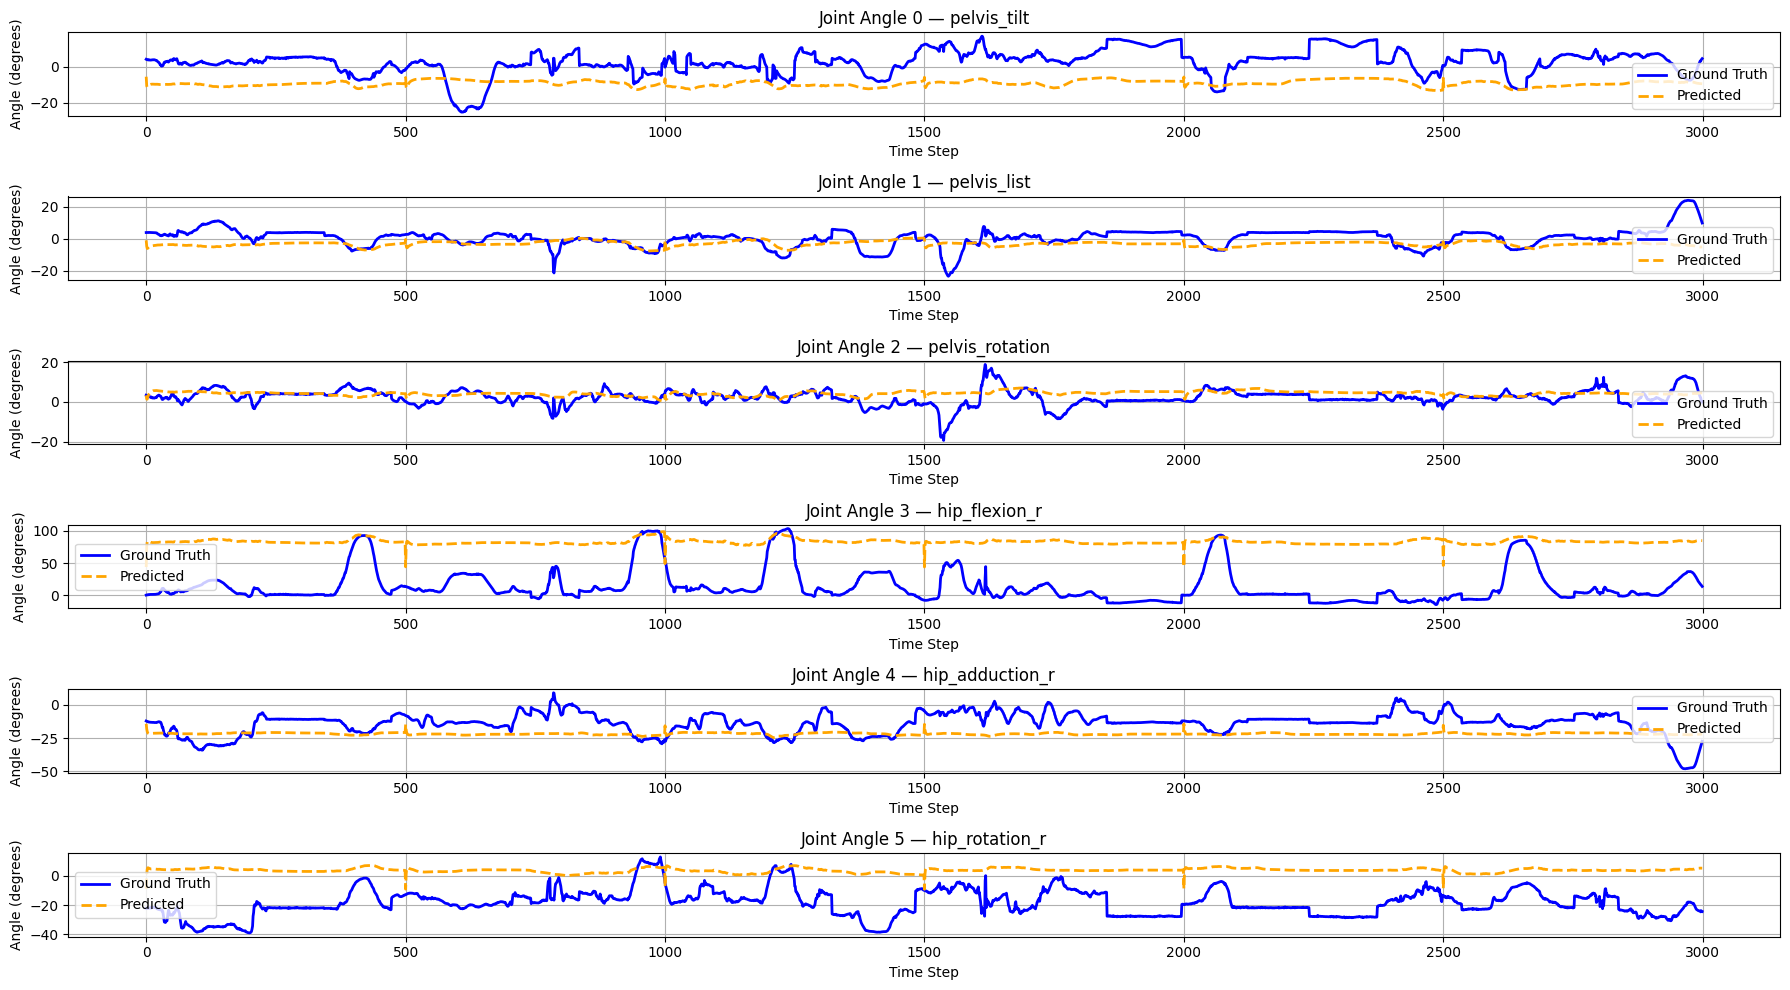


📊 Evaluation Metrics:
  MSE: 1533.0906444532027
  MAE: 23.57765010629991
  R2: -2.4449690778740285


In [ ]:
# Plot predictions from MediaPipe-style XYZ against ground truth joint angles from matched MoCap

# Load pre-trained model and scalers
model.load_state_dict(torch.load("lstm_mediapipe_model.pth"))
model.eval()

# Load data
mediapipe_df = pd.read_csv("mediapipe_xyz_S5.csv")
mocap_df = pd.read_csv("mocap_filtered_S5_matching_mediapipe.csv")

# Merge both on Activity, Trial, Frame to ensure perfect alignment
merged_df = pd.merge(
    mediapipe_df,
    mocap_df,
    on=["Activity", "Trial", "Frame"],
    suffixes=("_xyz", "_mocap")
)

print(f"✅ Merged aligned rows: {len(merged_df)}")

# Extract input and output data
input_xyz = merged_df[mediapipe_xyz_cols].values
ground_truth_angles = merged_df[joint_angle_columns].values

# Normalize input
norm_xyz = dataset.scaler_x.transform(input_xyz)

# Create windows for prediction
seq_len = 500
X = []
y = []
for i in range(0, len(norm_xyz) - seq_len + 1, seq_len):
    X.append(norm_xyz[i:i+seq_len])
    y.append(ground_truth_angles[i:i+seq_len])

if not X:
    print("❌ Not enough data for even one prediction window.")
else:
    X_tensor = torch.tensor(np.stack(X), dtype=torch.float32)
    y_true_all = np.vstack(y)

    # Predict
    with torch.no_grad():
        preds = model(X_tensor).numpy().reshape(-1, 36)
    preds_denorm = dataset.scaler_y.inverse_transform(preds)

    # =========================
    # Plot Actual vs Predicted
    # =========================
    def plot_actual_vs_predicted(preds, ground_truth, joint_angle_columns, channels=[0, 3, 5, 10]):
        time = np.arange(len(preds))
        plt.figure(figsize=(18, 10))

        for i, idx in enumerate(channels):
            plt.subplot(len(channels), 1, i + 1)
            plt.plot(time, ground_truth[:, idx], label='Ground Truth', color='blue', linewidth=2)
            plt.plot(time, preds[:, idx], '--', label='Predicted', color='orange', linewidth=2)
            plt.title(f"Joint Angle {idx} — {joint_angle_columns[idx]}")
            plt.xlabel("Time Step")
            plt.ylabel("Angle (degrees)")
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print metrics
        print("\n📊 Evaluation Metrics:")
        print("  MSE:", mean_squared_error(ground_truth, preds))
        print("  MAE:", mean_absolute_error(ground_truth, preds))
        print("  R2:", r2_score(ground_truth, preds))

    # Call plot
    # Choose a segment range — e.g., first 3000 steps
start = 0
end = 3000

plot_actual_vs_predicted(
    preds_denorm[start:end],
    y_true_all[start:end],
    joint_angle_columns,
    channels=[0, 1,2,3,4,5]
)
